#### **1) Libraries**

In [ ]:
# !pip install -U tensorflow_probability -q
# !pip install -q ipdb

In [ ]:
# prerequisites
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose  
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from tensorflow_probability import distributions
from scipy.stats import norm, gmean
from scipy import ndimage
from six.moves import urllib
import gzip
import time
import os

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#### **2) MNIST Data**

Preprocess image

In [ ]:
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
DATA_DIRECTORY = "data"

IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 0  

# DOWNLOAD
def try_download(filename):
    if not tf.io.gfile.exists(DATA_DIRECTORY):
        tf.io.gfile.makedirs(DATA_DIRECTORY)
    filepath = os.path.join(DATA_DIRECTORY, filename)
    if not tf.io.gfile.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        with tf.io.gfile.GFile(filepath) as f:
            size = f.size()
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

# GET IMAGES
def get_data(filename, num_images, norm_shift=False, norm_scale=True):
    print('geting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        if norm_shift:
            data = data - (PIXEL_DEPTH / 2.0)
        if norm_scale:
            data = data / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        data = np.reshape(data, [num_images, -1])
    return data

# GET LABELS
def get_labels(filename, num_images):
    """get the labels into a vector of int64 label IDs."""
    print('geting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        num_labels_data = len(labels)
        one_hot_encoding = np.zeros((num_labels_data,NUM_LABELS))
        one_hot_encoding[np.arange(num_labels_data),labels] = 1
        one_hot_encoding = np.reshape(one_hot_encoding, [-1, NUM_LABELS])
    return one_hot_encoding

# Augment training data
def expend_training_data(images, labels):

    expanded_images = []
    expanded_labels = []

    j = 0 
    for x, y in zip(images, labels):
        j = j+1
        if j%100==0:
            print ('expanding data : %03d / %03d' % (j, np.size(images,0)))

        # register original data
        expanded_images.append(x)
        expanded_labels.append(y)

        # get a value for the background
        # zero is the expected value, but median() is used to estimate background's value
        bg_value = np.median(x) 
        image = np.reshape(x, (-1, 28))

        for i in range(4):
            angle = np.random.randint(-15,15,1)
            new_img = ndimage.rotate(image,angle,reshape=False, cval=bg_value)

            # shift the image with random distance
            shift = np.random.randint(-2, 2, 2)
            new_img_ = ndimage.shift(new_img,shift, cval=bg_value)

            # register new training data
            expanded_images.append(np.reshape(new_img_, 784))
            expanded_labels.append(y)

    # images and labels are concatenated for random-shuffle at each epoch
    # notice that pair of image and label should not be broken
    expanded_train_total_data = np.concatenate((expanded_images, expanded_labels), axis=1)
    np.random.shuffle(expanded_train_total_data)

    return expanded_train_total_data

# MNIST DATA
def prepare_MNIST_data(use_norm_shift=False, use_norm_scale=True, use_data_augmentation=False):
    # Get the data.
    train_data_filename = try_download('train-images-idx3-ubyte.gz')
    train_labels_filename = try_download('train-labels-idx1-ubyte.gz')
    test_data_filename = try_download('t10k-images-idx3-ubyte.gz')
    test_labels_filename = try_download('t10k-labels-idx1-ubyte.gz')

    # get it into numpy arrays.
    train_data = get_data(train_data_filename, 60000, use_norm_shift, use_norm_scale)
    train_labels = get_labels(train_labels_filename, 60000)
    test_data = get_data(test_data_filename, 10000, use_norm_shift, use_norm_scale)
    test_labels = get_labels(test_labels_filename, 10000)

    # Generate a validation set.
    validation_data = train_data[:VALIDATION_SIZE, :]
    validation_labels = train_labels[:VALIDATION_SIZE,:]
    train_data = train_data[VALIDATION_SIZE:, :]
    train_labels = train_labels[VALIDATION_SIZE:,:]

    # Concatenate train_data & train_labels for random shuffle
    if use_data_augmentation:
        train_total_data = expend_training_data(train_data, train_labels)
    else:
        train_total_data = np.concatenate((train_data, train_labels), axis=1)

    train_size = train_total_data.shape[0]

    return train_total_data, train_size, train_data, train_labels, test_data, test_labels

Load the MNIST dataset

In [ ]:
train_total_data, train_size, X_train, y_train, X_test, y_test = prepare_MNIST_data(use_norm_shift=False, use_norm_scale=True, use_data_augmentation=False)
temp = np.argmax(y_test, axis=1)
y_test = temp

geting data/train-images-idx3-ubyte.gz
geting data/train-labels-idx1-ubyte.gz
geting data/t10k-images-idx3-ubyte.gz
geting data/t10k-labels-idx1-ubyte.gz


In [ ]:
X_train.shape, y_train.shape

((60000, 784), (60000, 10))

In [ ]:
X_test.shape[-1], y_test.shape

(784, (10000,))

#### **3) Model Class**

In [ ]:
class CoupledVAE:
    def __init__(self, coupling_dist, coupling_loss, train_dim, z_dim, seed,
                 batch_size=100, n_hidden=1024, dropout=0.05, learning_rate=1e-3,
                 initializer = keras.initializers.VarianceScaling()
                 # initializer=keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='normal')
                 ):
        """Convolutional variational autoencoder."""
        # Seed
        np.random.seed(seed)
        tf.random.set_seed(seed)
        # Global variables
        self.coupling_dist = coupling_dist
        self.coupling_loss = coupling_loss
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.dropout = dropout
        self.initializer = initializer
        # Plt plot
        plt.rc('font', size=100, weight='bold')          # controls default text sizes
        plt.rc('axes', titlesize=20)     # fontsize of the axes title
        plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
        plt.rc('legend', fontsize=20)    # legend fontsize
        # Encoder
        x = Input(shape=train_dim)
        self.encoder = self._build_encoder_network()  # VAEEncoder
        x_encoded = self.encoder(x)
        # Latent vector
        z = self._get_latent_vector(x_encoded)
        # Decoder
        self.decoder = self._build_decoder_network(train_dim)  # VAEDecoder
        y = self.decoder(z)
        y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)
        # Model
        self.model = self._build_coupled_vae(x, y, learning_rate)
        self.recognizer = Model(x, self.mean_vector)
        self.generator = self._build_generator()

    def _build_encoder_network(self):
        return keras.Sequential(
            [
                Dense(self.n_hidden, activation='elu', kernel_initializer=self.initializer, bias_initializer='zeros'),
                Dropout(self.dropout),
                Dense(self.n_hidden, activation='tanh', kernel_initializer=self.initializer, bias_initializer='zeros'),
                Dropout(self.dropout)
            ]
        )

    def _get_latent_vector(self, x_encoded):
        gaussian_params = Dense(self.z_dim*2, kernel_initializer=self.initializer, bias_initializer='zeros')(x_encoded)
        self.mean_vector = gaussian_params[:, :self.z_dim]
        self.std_vector = 1e-6 + tf.nn.softplus(gaussian_params[:, self.z_dim:])
        z = Lambda(self._sampling, output_shape=(self.z_dim,))([self.mean_vector, self.std_vector])
        return z

    def _sampling(self, args):
        mean_vector, std_vector = args
        assert self.coupling_dist >= 0, "Coupling distribution variable must be greater or equal to 0." 
        if self.coupling_dist == 0:
            # Use normal Gaussian if coupling_dist == 0
            # Reparameterization trick
            eps = K.random_normal(shape=(self.batch_size, self.z_dim), mean=0., stddev=1.0)
        else:
            # Use Student-T (approx. coupled-Gaussian) if coupling_dist > 0
            mvt = distributions.MultivariateStudentTLinearOperator(df=1/self.coupling_dist,
                                                                   loc=np.zeros(self.z_dim),
                                                                   # sqrt(1 - 2 * coupling_dist) so target std limits to 1 
                                                                   scale=tf.linalg.LinearOperatorLowerTriangular(np.identity(self.z_dim))
                                                                   )
            # Modify epsilon to sample from Coupled-gaussians instead of Gaussians.
            eps = mvt.sample(sample_shape=(self.batch_size))
            eps = tf.dtypes.cast(eps, tf.float32)
        return mean_vector + K.exp(std_vector)*math.sqrt(self.coupling_dist)*eps #mean_vector + (K.exp(std_vector)*math.sqrt(1 - 2*self.coupling_dist))*eps

    def _build_decoder_network(self, train_dim):
        return keras.Sequential(
            [
                Dense(self.n_hidden, activation='tanh', kernel_initializer=self.initializer, bias_initializer='zeros'),
                Dropout(self.dropout),
                Dense(self.n_hidden, activation='elu', kernel_initializer=self.initializer, bias_initializer='zeros'),
                Dropout(self.dropout),
                Dense(train_dim[0], activation='sigmoid', kernel_initializer=self.initializer, bias_initializer='zeros')
            ]
        )

    def _build_coupled_vae(self, x, y, learning_rate):
        model = Model(x, y)
        model.add_loss(self._compute_loss(x, y))
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=opt)
        return model

    def _compute_loss(self, x, y):
        coupling_loss = self.coupling_loss
        mean_vector = self.mean_vector
        std_vector = self.std_vector
        d = self.z_dim
        # Nonextensive statistical mechanics
        # q_tsallis = 1 + 2*coupling_loss/(1 + d*coupling_loss)
        d1 = 1 + d*coupling_loss + 2*coupling_loss  # What is d1?
        #### Latent loss and image loss for Coupled VAE.
        marginal_likelihood = tf.reduce_sum(x * tf.subtract(tf.pow(y, (2*coupling_loss) / (1 + coupling_loss)), 1) / (2*coupling_loss) + (1 - x)
                                            * tf.subtract(tf.pow(1 - y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (coupling_loss*2), 1)
        kl_d1 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi), coupling_loss/(1 + d*coupling_loss)) * tf.sqrt(d1 / (d1 - 2*coupling_loss*tf.square(std_vector)))
                            * tf.exp(tf.square(mean_vector)*d1*coupling_loss / (1 + d*coupling_loss) / (d1 - 2*coupling_loss*tf.square(std_vector))), 1)
        kl_d2 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi)*tf.square(std_vector),
                                    coupling_loss / (1 + coupling_loss*d)) * tf.sqrt(d1 / (1 + d*coupling_loss)), 1)
        kl_divergence = (kl_d1 - kl_d2) / coupling_loss / 2
        kl_divergence = tf.reduce_mean(kl_divergence)
        marginal_likelihood = tf.reduce_mean(marginal_likelihood)
        # ELBO method
        elbo = marginal_likelihood - kl_divergence
        vae_loss = -elbo
        return vae_loss

    def _build_generator(self):
        decoder_input = Input(shape=(self.z_dim,))
        _y = self.decoder(decoder_input)
        generator = Model(decoder_input, _y)
        return generator

    def summary(self):
        return self.model.summary()

    def generator_summary(self):
        return self.generator.summary()

    def fit(self, X_train, **kwargs):
        self.model.fit(X_train, **kwargs)

    def display(self, X_test, y_test, n=15, digit_size=28):
        # Display latent space
        self._display_latent_space(X_test, y_test)
        # Display a 2D manifold of the digits, with 15x15 digits figure
        if self.z_dim == 2:
            self._display_manifold(n, digit_size, X_test)
        # Get overall_values
        overall_values = self._get_overall_values(X_test)
        # Display histogram (passed in 'overall_original_values' as overall_values)
        self._display_histogram(overall_values)

    def _display_latent_space(self, X_test, y_test):
        # Plot of the digit classes in the latent space
        X_test_latent = self.recognizer.predict(X_test, batch_size=self.batch_size)
        colors = ['pink', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'gray']
        plt.figure(figsize=(10, 10))
        plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test, 
                    cmap=matplotlib.colors.ListedColormap(colors)
                    )
        plt.colorbar()
        plt.show()

    def _get_overall_values(self, X_test):
        coupling_loss = self.coupling_loss
        overall_values = []
        for i in range(len(X_test)):
          input_test = np.resize(X_test[i],(1,784))
          output = self.model.predict(input_test)
          x = input_test
          y = output[0]

          x = tf.convert_to_tensor(x)
          y = tf.convert_to_tensor(y)

          marginal_likelihood = tf.reduce_mean(tf.reduce_sum(x * tf.subtract(tf.pow(y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (2 * coupling_loss) + (1 - x)
                                                * tf.subtract(tf.pow(1 - y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (coupling_loss * 2), 1))
          marginal_likelihood = tf.cast(marginal_likelihood, tf.float32).numpy()
          overall_values.append(marginal_likelihood)
        return overall_values

    def _display_manifold(self, n, digit_size, X_test):
        figure = np.zeros((digit_size * n, digit_size * n))
        grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
        grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
        # Display a 2D manifold of the digits and also output overall values
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                #z_sample = np.array([[xi, yi]])
                #x_decoded = self.generator.predict(z_sample)
                #digit = x_decoded[0].reshape(digit_size, digit_size)
                input_test = np.resize(X_test[j*len(grid_x) + i],(1,784))
                output = self.model.predict(input_test)
                digit = output[0].reshape(digit_size, digit_size)
                #digit = input_test.reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

        plt.figure(figsize=(20, 20))
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

    def _display_histogram(self, overall_values):
        log_probability_values = self._calculate_generalized_mean(overall_values)
        # The histogram of the data
        fig, ax = plt.subplots(figsize=(24, 10))
        xtick_labels = ['1e-240', '1e-210', '1e-180', '1e-150', '1e-120', '1e-90', '1e-60', '1e-30', '1']
        ax.set_xticks([math.log(1e-240), math.log(1e-210), math.log(1e-180), math.log(1e-150), math.log(1e-120), math.log(1e-90), math.log(1e-60), math.log(1e-30), math.log(1)])
        ax.set_xticklabels(xtick_labels)
        plt.title('Histogram for Coupled VAE', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.xlabel('Probability of reconstructed image equivalent to original one.', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.ylabel('Frequency in logscale.', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.axvline(self.log_decisiveness, color='r', linestyle='dashed', linewidth=2)
        plt.axvline(self.log_accuracy, color='b', linestyle='dashed', linewidth=2)
        plt.axvline(self.log_robustness, color='g', linestyle='dashed', linewidth=2)
        plt.hist(log_probability_values, log=True, bins=100, facecolor='white', edgecolor='black')
        plt.show();

    def _calculate_generalized_mean(self, overall_values):
        probability_values = [math.exp(record) for record in overall_values]
        self.log_decisiveness = math.log(self._calculate_decisiveness(probability_values))
        self.log_accuracy = math.log(self._calculate_accuracy(probability_values))
        self.log_robustness = math.log(self._calculate_robustness(probability_values))
        log_probability_values = [math.log(record) for record in probability_values]
        return log_probability_values

    def _calculate_decisiveness(self, overall_values): 
        result = sum(overall_values) / float(len(overall_values))
        return result

    def _calculate_accuracy(self, overall_values) : 
        # Multiply elements one by one 
        result = 1
        for x in overall_values: 
            temp = x ** (1/float(len(overall_values))) 
            result = result * temp
        return result

    def _calculate_robustness(self, overall_values):
        result = 0
        for x in overall_values:
            result = result + (x ** (-2/3))
        result = (result / float(len(overall_values))) ** (-3/2)
        return result

    def get_generalized_mean(self):
        print(f"Decisiveness (Arithmetic Mean): {math.exp(self.log_decisiveness):.4e}")
        print(f"Accuracy (Geometric Mean): {math.exp(self.log_accuracy):.4e}")
        print(f"Robustness (-2/3 Mean): {math.exp(self.log_robustness):.4e}")
        return math.exp(self.log_decisiveness), math.exp(self.log_accuracy), math.exp(self.log_robustness)

#### **4) Model Test**

In [ ]:
def run_cvae_loop(X_train, X_test, y_test, coupling_dist_list, coupling_loss_list, seed_list,
                  z_dim=2, batch_size=100, n_epoch = 100, n_hidden = 1024, dropout=0.05,
                  learning_rate=1e-3, shuffle=True, verbose=1,
                  ):

    comparison = {}
    for seed in seed_list:
        comparison_df = pd.DataFrame(columns=['coupling_dist','coupling_loss','log_decisiveness','log_accuracy','log_robustness'])
        for coupling_dist in coupling_dist_list:
            for coupling_loss in coupling_loss_list:
                print("=====================================================================================")
                print(f"Coupling Distribution: {coupling_dist}, Coupling Loss: {coupling_loss}, Seed: {seed}")
                start_time = time.time()
                cvae = CoupledVAE(coupling_dist=coupling_dist,
                                  coupling_loss=coupling_loss,
                                  train_dim=X_train.shape[1:],
                                  z_dim=z_dim,
                                  batch_size=batch_size,
                                  n_hidden=n_hidden,
                                  dropout=dropout,
                                  learning_rate=learning_rate,
                                  seed=seed
                                  )
                # cvae.summary()
                cvae.fit(X_train,
                        shuffle=shuffle,
                        epochs=n_epoch,
                        batch_size=batch_size,
                        validation_data=(X_test, None),
                        verbose=verbose,
                        )
                try:
                    cvae.display(X_test, y_test)
                    log_decisiveness, log_accuracy, log_robustness = cvae.get_generalized_mean()
                except ValueError:
                    log_decisiveness, log_accuracy, log_robustness = np.NaN, np.NaN, np.NaN, 
                    print("Failed to retrieve generalized mean values due to ValueError, thus set to NaN.")
                end_time = time.time()
                run_time = (end_time - start_time)/60
                print(f"Run time: {run_time:.2f} min")
                print()
                comparison_df = comparison_df.append({'coupling_dist': coupling_dist,
                                                      'coupling_loss': coupling_loss,
                                                      'log_decisiveness': log_decisiveness,
                                                      'log_accuracy': log_accuracy,
                                                      'log_robustness': log_robustness,
                                                      'run_time': run_time,
                                                      }, ignore_index=True
                                                     )
        comparison[seed] = comparison_df
    return comparison

In [ ]:
coupling_dist_list = [1e-6, 0.15]
coupling_loss_list = [1e-6, 0.15]
# matrix code
#coupling_dist_list = [0, 0.01, 0.05, 0.1]  # pick 4
#coupling_loss_list = [1e-6, 0.05, 0.1, 0.15]  # pick 4
seed_list = [0]
# seed_list = [0, 1, 2, 10, 25, 42, 50, 64, 78, 99]
# train_dim = X_train.shape[1:]
z_dim = 2

batch_size = 5000
n_epoch = 500
n_hidden = 500
dropout = 0.1
learning_rate = 1e-3
# shuffle = True
verbose = 0

Coupling Distribution: 1e-06, Coupling Loss: 1e-06, Seed: 0
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


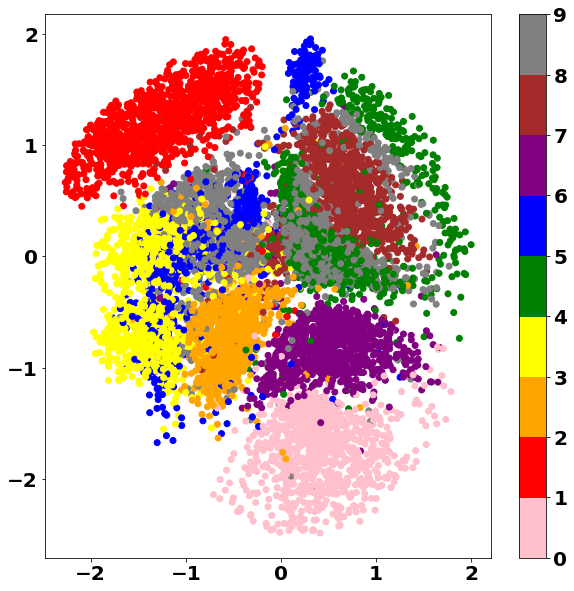

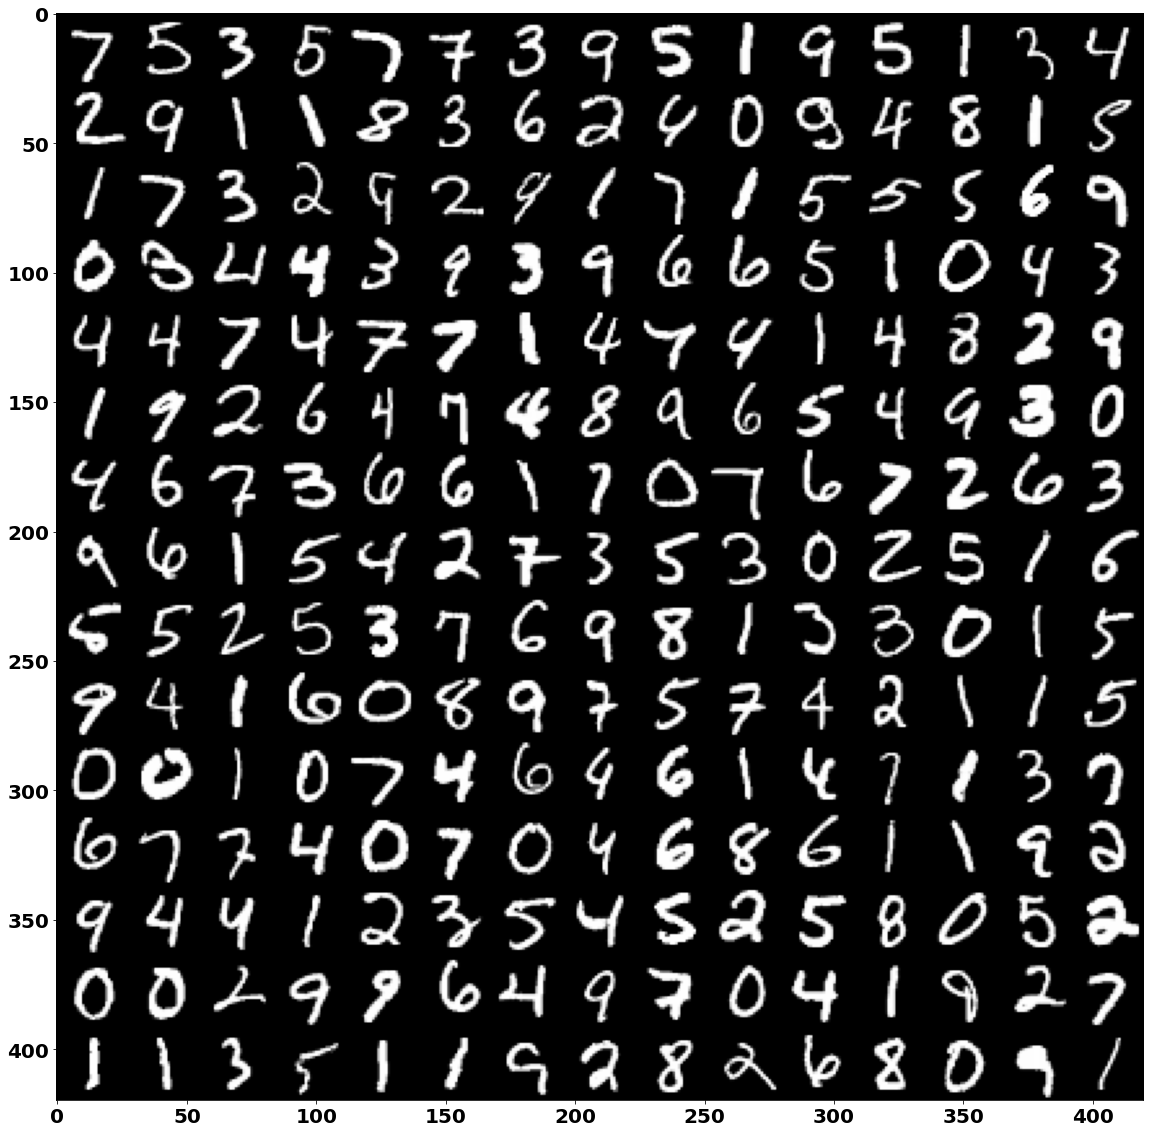

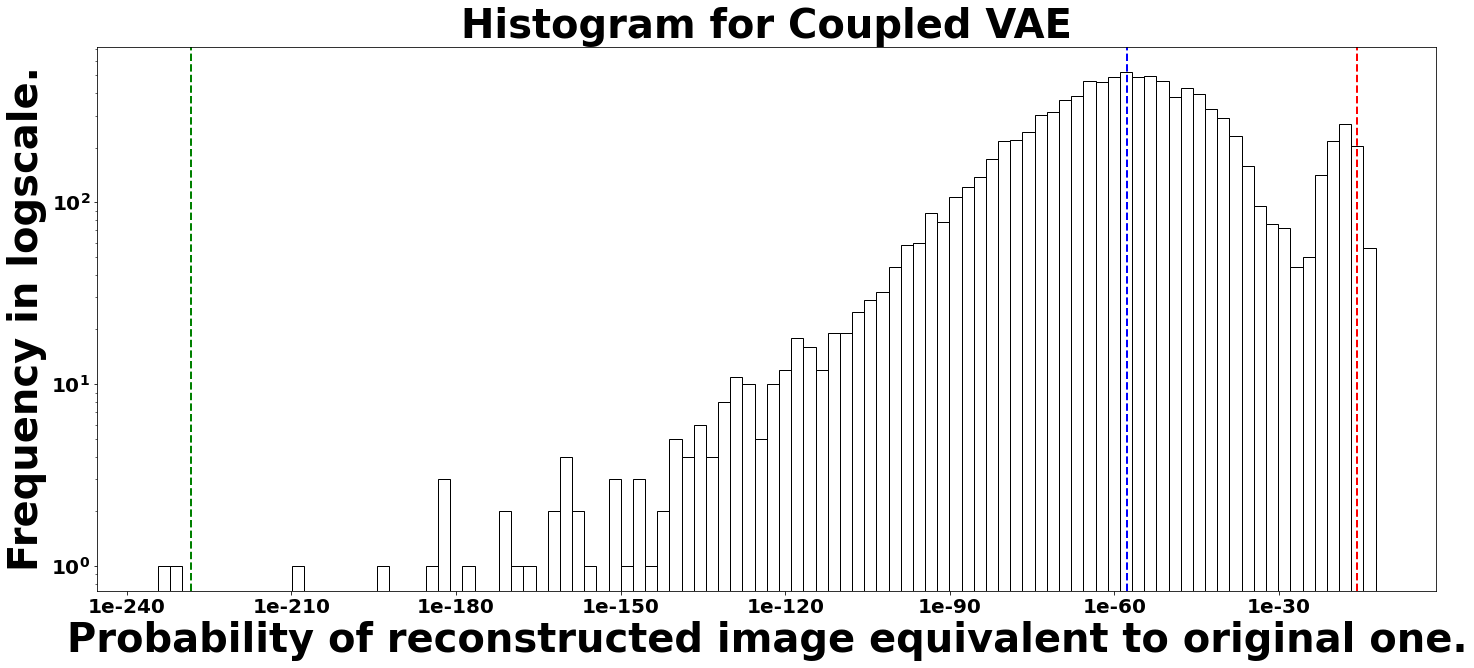

Decisiveness (Arithmetic Mean): 1.5225e-16
Accuracy (Geometric Mean): 2.2384e-58
Robustness (-2/3 Mean): 5.0055e-229
Run time: 8.78 min

Coupling Distribution: 1e-06, Coupling Loss: 0.15, Seed: 0


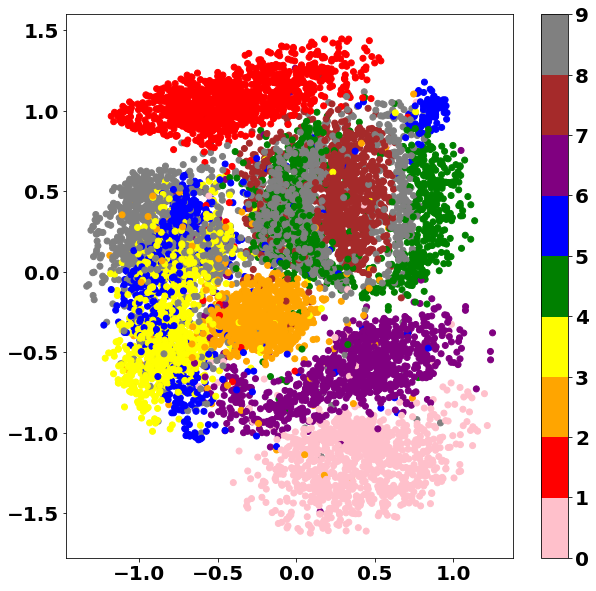

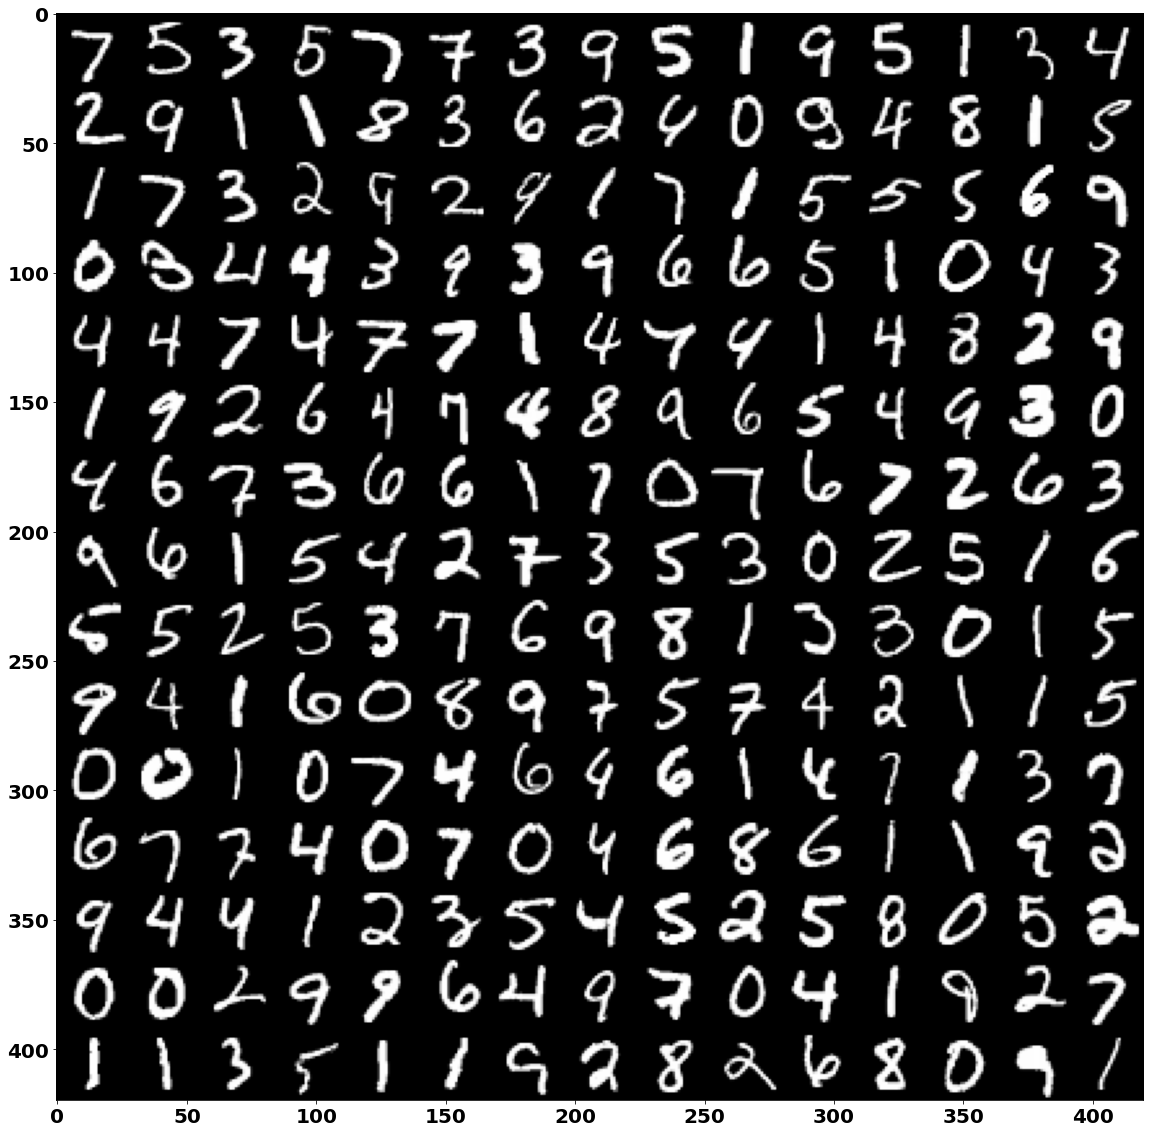

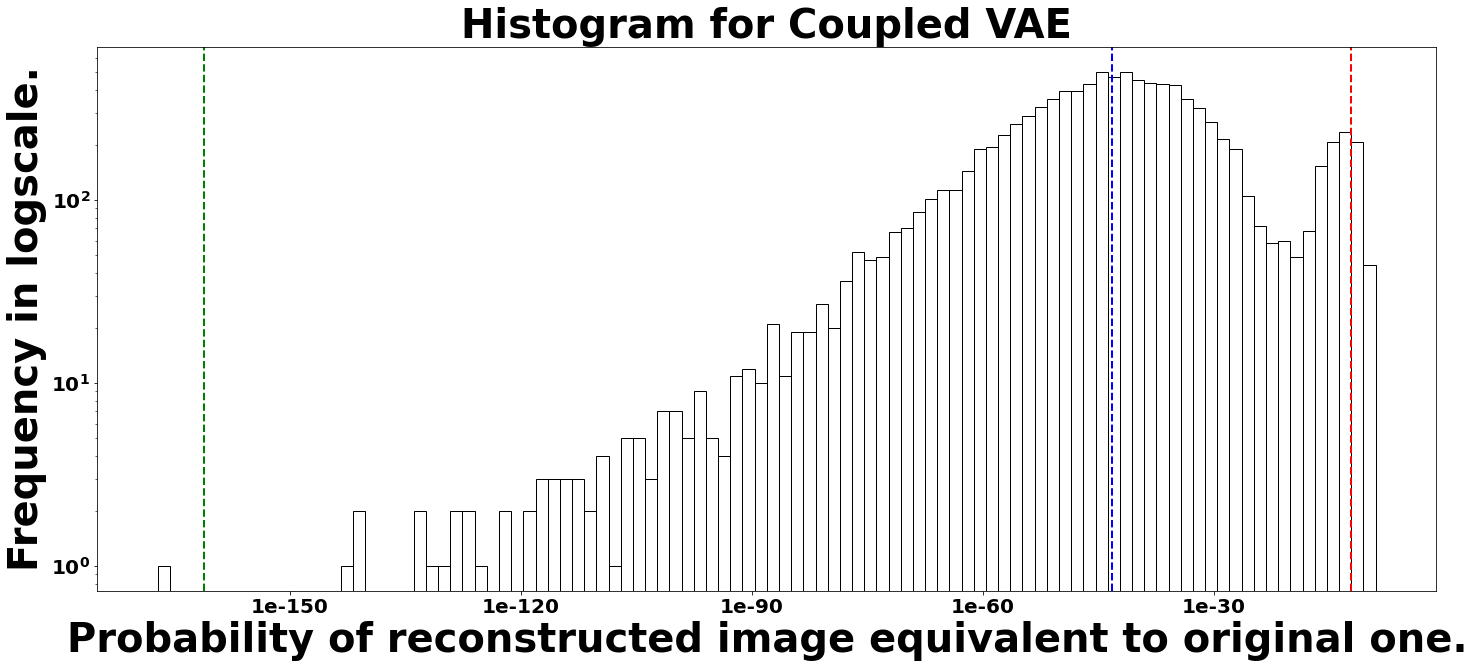

Decisiveness (Arithmetic Mean): 7.2250e-13
Accuracy (Geometric Mean): 6.4455e-44
Robustness (-2/3 Mean): 7.1267e-162
Run time: 8.83 min

Coupling Distribution: 0.15, Coupling Loss: 1e-06, Seed: 0


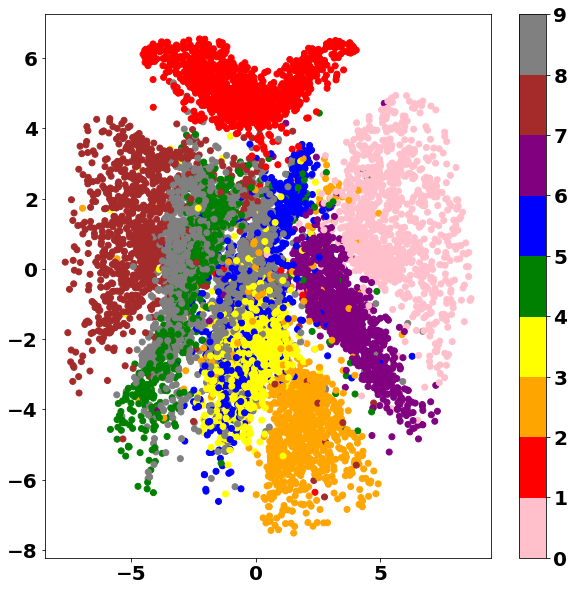

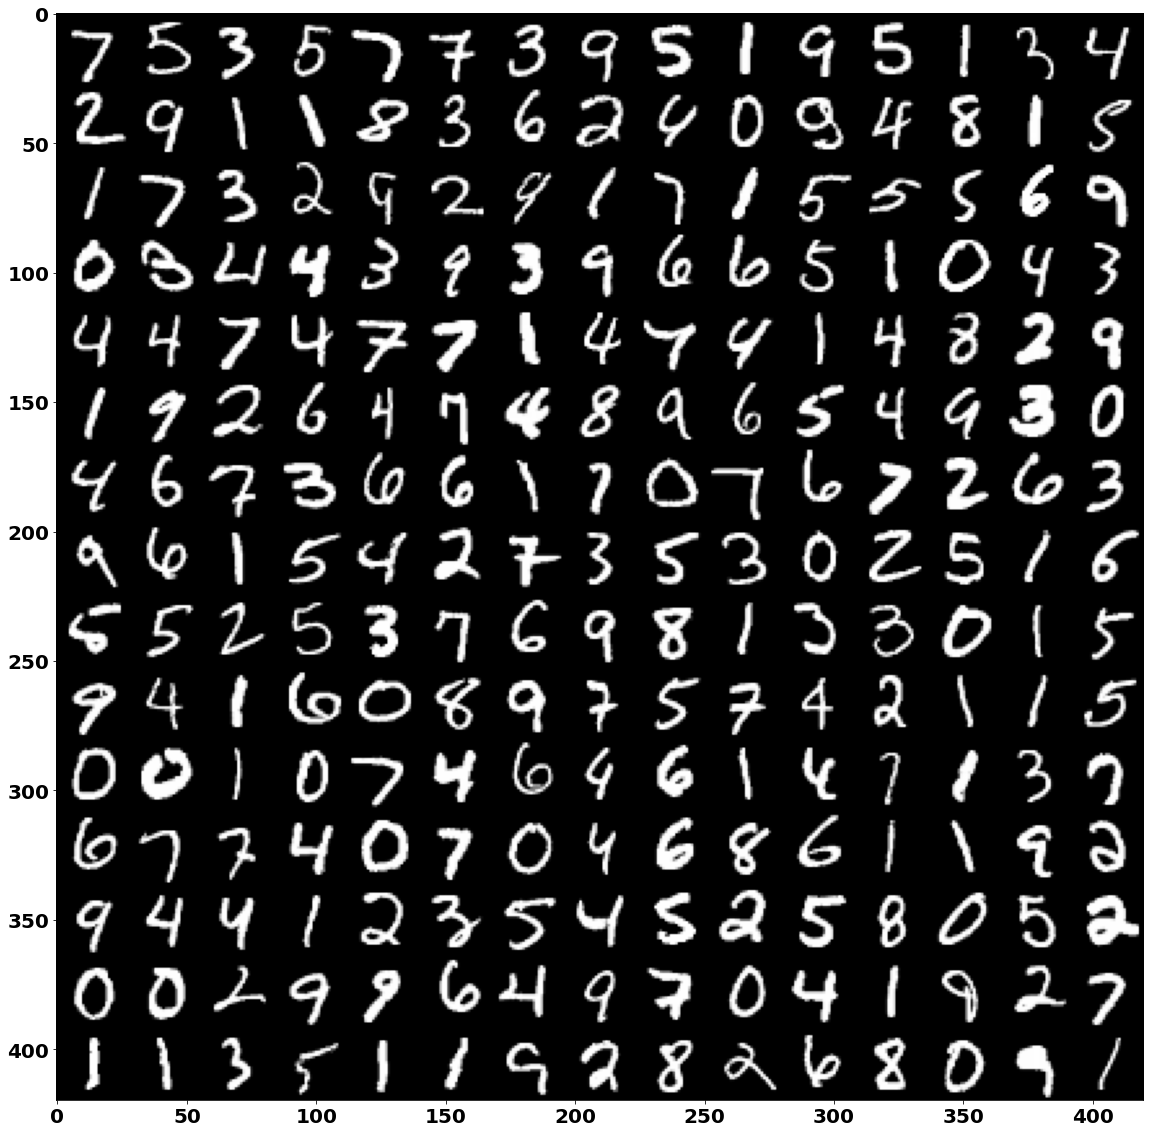

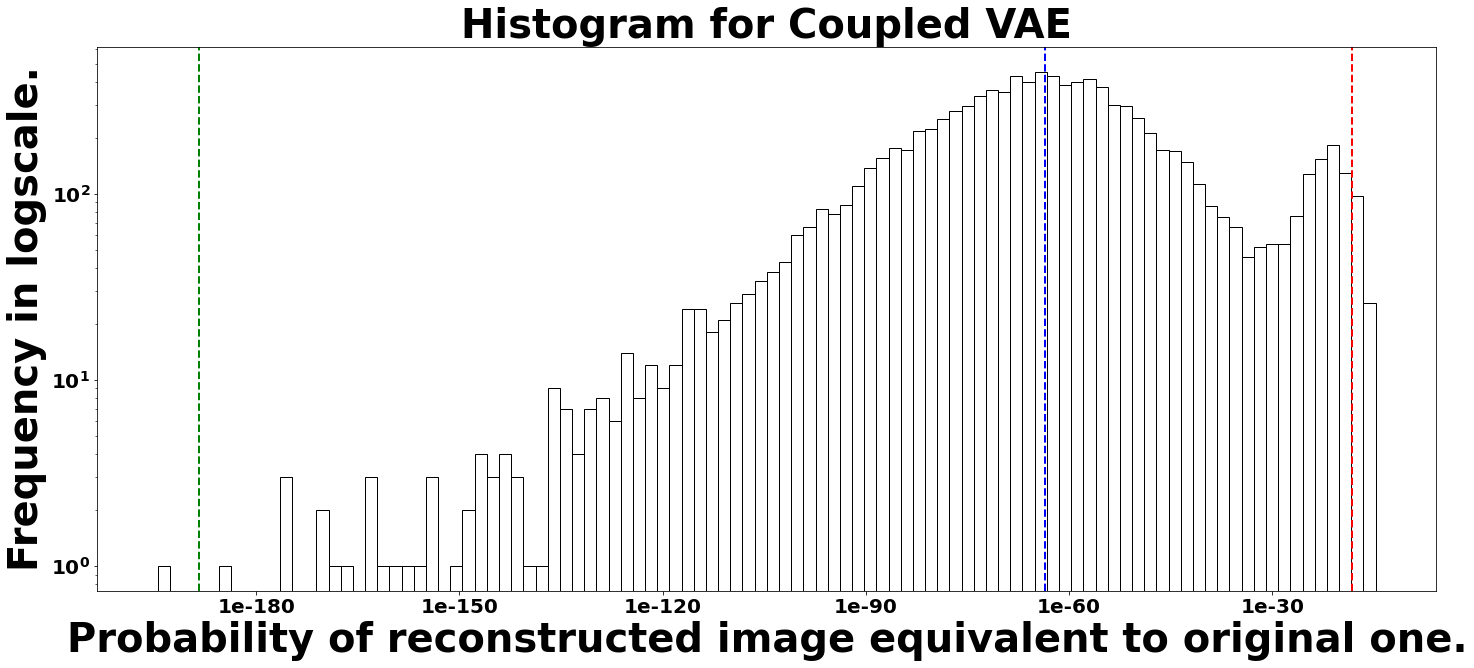

Decisiveness (Arithmetic Mean): 6.8952e-19
Accuracy (Geometric Mean): 2.6285e-64
Robustness (-2/3 Mean): 3.2286e-189
Run time: 8.88 min

Coupling Distribution: 0.15, Coupling Loss: 0.15, Seed: 0


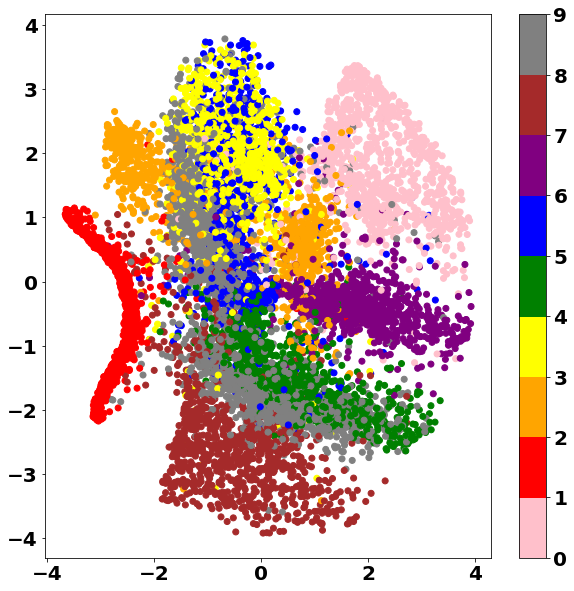

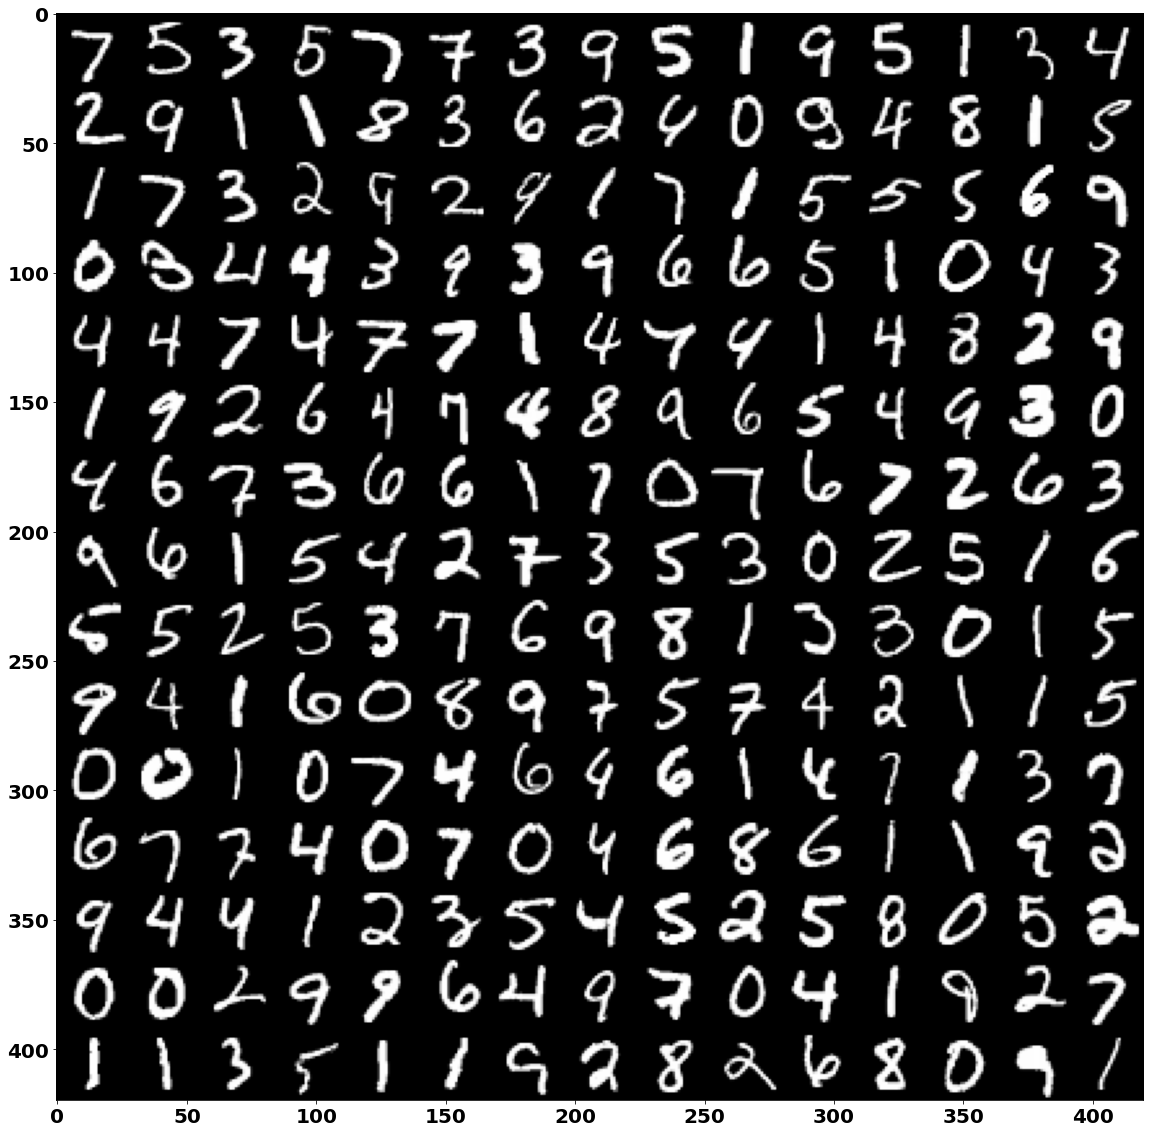

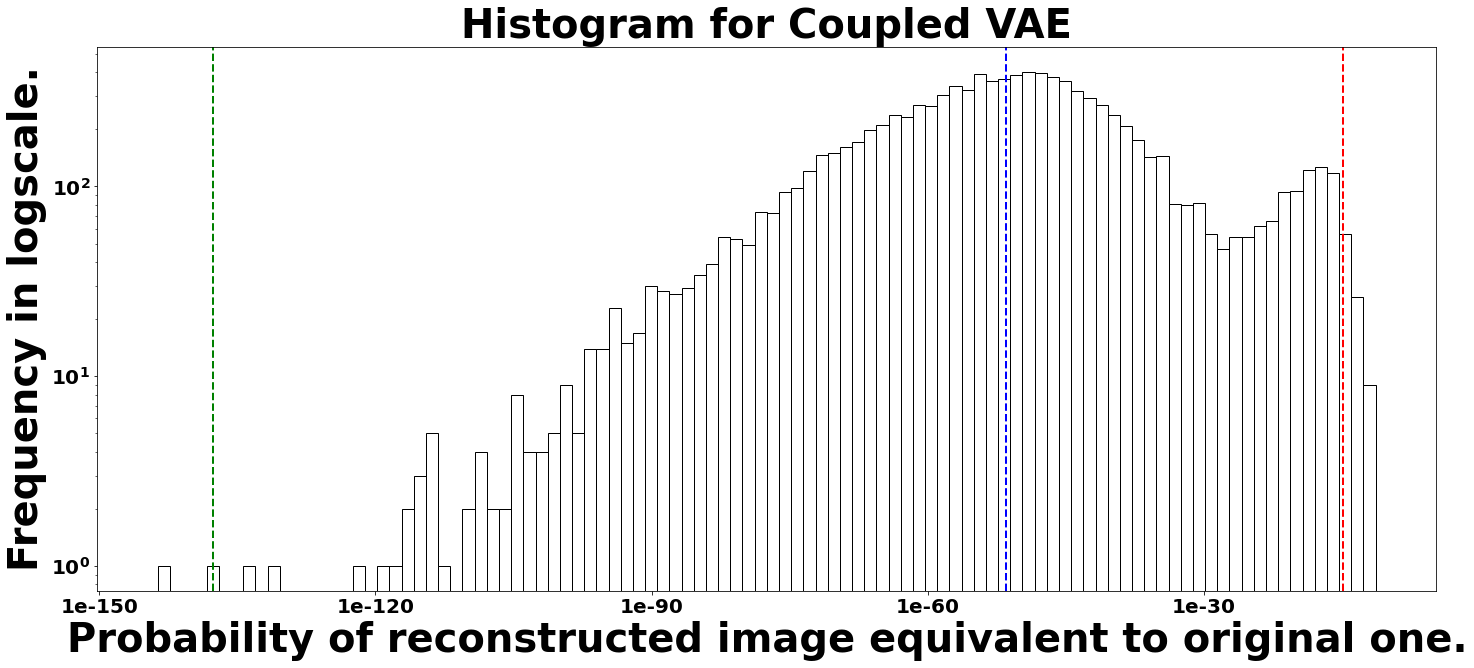

Decisiveness (Arithmetic Mean): 1.1489e-15
Accuracy (Geometric Mean): 3.1883e-52
Robustness (-2/3 Mean): 2.4781e-138
Run time: 8.79 min

CPU times: user 38min 56s, sys: 2min 51s, total: 41min 47s
Wall time: 35min 16s


In [ ]:
%%time
comparison = run_cvae_loop(X_train, X_test, y_test, coupling_dist_list, coupling_loss_list, seed_list,
                           z_dim=z_dim, batch_size=batch_size, n_epoch=n_epoch, n_hidden=n_hidden,
                           learning_rate=learning_rate, verbose=verbose
                           )

In [ ]:
for seed in seed_list:
    print(comparison[seed])
    comparison[seed].to_csv(f"comparison_s{seed}.csv", header=True, index=False)

   coupling_dist  coupling_loss  ...  log_robustness  run_time
0       0.000001       0.000001  ...   5.005506e-229  8.775554
1       0.000001       0.150000  ...   7.126660e-162  8.830726
2       0.150000       0.000001  ...   3.228642e-189  8.877882
3       0.150000       0.150000  ...   2.478096e-138  8.787300

[4 rows x 6 columns]
